In [1]:
%matplotlib
import torch
import torch.nn.functional as F

import torch_geometric
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_dense_adj, add_self_loops
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx

import os
os.chdir("../")

import sys
sys.path.append('../scripts')

# loading scripts from here
from eval_link_prediction import accuracy, precision, recall
from link_prediction import negative_sampling, balanced_samples

"""
This is an implementation from:
https://github.com/tkipf/pygcn/blob/master/pygcn/layers.py

Author: Thomas kipf
Paper: 
Semi-Supervised Classification with Graph Convolutional Networks
https://arxiv.org/abs/1609.02907
"""

from GCNConv import GraphConvolution

Using matplotlib backend: agg


## GraphSAGE

In [2]:
"""
This is an implementation from:
https://github.com/tkipf/pygcn/blob/master/pygcn/models.py

Model and training settings are from:
https://github.com/tkipf/pygcn/blob/master/pygcn/train.py
which is the same as reported from the paper.

Author: Thomas kipf
"""
class Net(torch.nn.Module):
    def __init__(self, in_channel, out_channel, data):
        super(Net, self).__init__()

        self.gc1 = GraphConvolution(in_channel, 16)
        self.gc2 = GraphConvolution(16, out_channel)
        
        # predict exists or not
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(2 * out_channel, 50),
            torch.nn.ELU(),
            torch.nn.Linear(50, 1),
            torch.nn.Sigmoid()
        )
        
        # link injection intialized
        injection = torch.ones_like(data.adj) * 0.01
        injection = torch.abs(injection)
        self.injection = torch.nn.Parameter(
            injection, 
            requires_grad=True
        )
        
    def forward(self, data, query_index):
        x, adj = data.x, data.adj
        
        # link injection
        injection = F.relu(self.injection)
        adj = adj + injection
        adj = torch.clamp(adj, 0, 1)
        
        # generate node embeddings 
        emb = F.relu(self.gc1(x, adj))
        emb = F.dropout(emb, p=0.5, training=self.training)
        emb = self.gc2(emb, adj)
        
        # get queried embeddings
        emb_query = torch.cat((emb[query_index[0]], emb[query_index[1]]), dim=1)
        
        # using embeddings to get score out
        score = self.layers(emb_query)
        return score
    
    def get_weight(self, data, query_index):
        adj = data.adj.detach()
        
        # link injection
        injection = F.relu(self.injection.detach())
        adj = adj + injection
        adj = torch.clamp(adj, 0, 1)
        
        # weight
        weights = adj[query_index[0], query_index[1]].view(-1, 1)
        return weights

## Split Dataset

In [3]:
# set device
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# load data
name = 'Cora'
dataset = Planetoid('../datasets/'+ name, name=name)
data = dataset.data

# random sampling edges
train_frac = 0.8
val_frac = 0.1
test_frac = 0.1

# split edges
edges = data.edge_index.detach().cpu().numpy().T
edge_train, edge_test = train_test_split(edges, train_size=train_frac, random_state=42)
edge_val, edge_test = train_test_split(
    edge_test, 
    train_size=val_frac/(test_frac + val_frac), 
    random_state=42
)

# create train, validation, test positive edges
data.edge_train = torch.Tensor(edge_train).long().t()
data.edge_val = torch.Tensor(edge_val).long().t()
data.edge_test = torch.Tensor(edge_test).long().t()
data.y_train = torch.ones(len(edge_train), 1).long().t()
data.y_val = torch.ones(len(edge_val), 1).long().t()
data.y_test = torch.ones(len(edge_test), 1).long().t()

# create adjacency matrix
data.adj = to_dense_adj(add_self_loops(data.edge_train)[0])[0]

# to device (GPU default)
data = dataset.data.to(device)

# record the 
num_nodes = data.x.shape[0]
num_edges = data.edge_index.shape[1]
num_train = len(data.edge_train.t())
num_val = len(data.edge_val.t())
num_test = len(data.edge_test.t())

print('Number of nodes =', num_nodes)
print('Number of edges =', num_edges)
print('Training edges =', num_train)
print('Validation edges =', num_val)
print('Test edges =', num_test)

Number of nodes = 2708
Number of edges = 10556
Training edges = 8444
Validation edges = 1056
Test edges = 1056


## Compile Model

In [4]:
from tqdm import tqdm

NUMEPOCHS = 30000
early_stop_win_size = 100
tolerance = 1.00

# compile model
in_dim = data.x.shape[1]

model = Net(
    in_dim,
    50,
    data
).to(device)

optimizer = torch.optim.Adamax(model.parameters(), weight_decay=1e-4)

criterion = torch.nn.modules.loss.BCELoss()

# Training

In [5]:
# get the initial injection
injection_init = F.relu(model.injection.detach() - data.adj.detach())
injection_init = injection_init.cpu().numpy()

In [6]:
# record accuracy
train_loss = np.zeros(NUMEPOCHS)
val_loss = np.zeros(NUMEPOCHS)
test_loss = np.zeros(NUMEPOCHS)

# tracking injection
injection_sum = np.zeros(NUMEPOCHS)

# negative sampling
edge_test, y_test = balanced_samples(data.edge_test, num_nodes)
y_test_injected = model.get_weight(data, edge_test)

# training start
for epoch in range(NUMEPOCHS):
    # negative sampling
    edge_train, y_train = balanced_samples(data.edge_train, num_nodes)
    edge_val, y_val = balanced_samples(data.edge_val, num_nodes)
    
    # consistent with prediction
    y_train = model.get_weight(data, edge_train)
    
    model.train()
    optimizer.zero_grad()
    out = model(data, edge_train)
    loss = criterion(out, y_train.float())
    loss.backward()
    optimizer.step()
    
    # record the loss
    train_loss[epoch] = loss.item()
    model.eval()
    val_loss[epoch] = criterion(model(data, edge_val), y_val.float()).item()
    test_loss[epoch] = criterion(model(data, edge_test), y_test.float()).item()
    
    # get the injection
    injection = F.relu(model.injection.detach()).cpu().numpy()
    injection_sum[epoch] = np.sum(injection)
    
    if epoch % 500 == 0:
        print(
            epoch, 
            ', train loss =', loss.item(),
            ', val loss =', val_loss[epoch], 
        )

0 , train loss = 4.304260730743408 , val loss = 4.666313171386719
500 , train loss = 0.25930139422416687 , val loss = 0.38837501406669617
1000 , train loss = 0.18931929767131805 , val loss = 0.3398035764694214
1500 , train loss = 0.1234329342842102 , val loss = 0.2913265824317932
2000 , train loss = 0.10543285310268402 , val loss = 0.28292760252952576
2500 , train loss = 0.1017109602689743 , val loss = 0.28825491666793823
3000 , train loss = 0.0909539982676506 , val loss = 0.2942579984664917
3500 , train loss = 0.09120620042085648 , val loss = 0.3055099546909332
4000 , train loss = 0.08463405072689056 , val loss = 0.3255297839641571
4500 , train loss = 0.0819641724228859 , val loss = 0.3165784180164337
5000 , train loss = 0.07371539622545242 , val loss = 0.3557782769203186
5500 , train loss = 0.0783485397696495 , val loss = 0.3280532658100128
6000 , train loss = 0.06664935499429703 , val loss = 0.3554617762565613
6500 , train loss = 0.06884191185235977 , val loss = 0.3802222013473511
7

In [7]:
# get the initial injection
injection_final = F.relu(model.injection.detach() - data.adj.detach())
injection_final = injection_final.cpu().numpy()

In [8]:
print('Initial injection = \n', injection_init)
print('\nSum inital = %d\n' % np.sum(injection_init))
print('Final injection = \n', injection_final)
print('\nSum final = %d\n' % np.sum(injection_final))

Initial injection = 
 [[0.   0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.   0.01 ... 0.01 0.01 0.01]
 [0.01 0.   0.   ... 0.01 0.01 0.01]
 ...
 [0.01 0.01 0.01 ... 0.   0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.   0.  ]
 [0.01 0.01 0.01 ... 0.01 0.   0.  ]]

Sum inital = 73221

Final injection = 
 [[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.0497995e-02
  0.0000000e+00 2.7422155e-03]
 [1.2213739e-02 0.0000000e+00 0.0000000e+00 ... 3.6892153e-03
  3.9461162e-03 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [0.0000000e+00 0.0000000e+00 7.0105954e-03 ... 0.0000000e+00
  2.5698130e-03 0.0000000e+00]
 [3.5420589e-03 4.7630212e-05 5.8662478e-04 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.7188861e-06 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]]

Sum final = 12803



In [26]:
np.save('../variables/injection_sum_gcn', injection_sum)
np.save('../variables/injection_final_gcn', injection_final)
np.save('../variables/injection_init_gcn', injection_init)

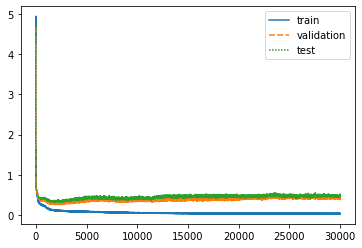

In [9]:
df_acc = pd.DataFrame({
    'train': train_loss,
    'validation': val_loss,
    'test': test_loss
})

sns.lineplot(data=df_acc)
plt.show()

In [10]:
edge_train, y_train = balanced_samples(data.edge_train, num_nodes)
edge_val, y_val = balanced_samples(data.edge_val, num_nodes)
edge_test, y_test = balanced_samples(data.edge_test, num_nodes)

train_score = model(data, edge_train).detach().cpu().numpy().ravel()
val_score = model(data, edge_val).detach().cpu().numpy().ravel()
test_score = model(data, edge_test).detach().cpu().numpy().ravel()

train_pred = (train_score > 0.5).astype(np.int8)
val_pred = (val_score > 0.5).astype(np.int8)
test_pred = (test_score > 0.5).astype(np.int8)

print('Train Accuracy: {:.4f}'.format(accuracy(train_pred, y_train)))
print('Validation Accuracy: {:.4f}'.format(accuracy(val_pred, y_val)))
print('Test Accuracy: {:.4f}'.format(accuracy(test_pred, y_test)))

print('Train Precision: {:.4f}'.format(precision(train_pred, y_train)))
print('Validation Precision: {:.4f}'.format(precision(val_pred, y_val)))
print('Test Precision: {:.4f}'.format(precision(test_pred, y_test)))

print('Train Recall: {:.4f}'.format(recall(train_pred, y_train)))
print('Validation Recall: {:.4f}'.format(recall(val_pred, y_val)))
print('Test Recall: {:.4f}'.format(recall(test_pred, y_test)))

Train Accuracy: 0.9963
Validation Accuracy: 0.9394
Test Accuracy: 0.9356
Train Precision: 0.9927
Validation Precision: 0.9926
Test Precision: 0.9925
Train Recall: 1.0000
Validation Recall: 0.8854
Test Recall: 0.8778


In [11]:
test_acc_all = np.array([0.9347, 0.9413, 0.9413, 0.9413, 0.9408])
test_precision_all = np.array([0.9713, 0.9854, 0.9854, 0.9864, 0.9885])
test_recall_all = np.array([0.8958, 0.8958, 0.8958, 0.8949, 0.8920])

print(np.mean(test_acc_all))
print(np.mean(test_precision_all))
print(np.mean(test_recall_all))

print(np.std(test_acc_all))
print(np.std(test_precision_all))
print(np.mean(test_recall_all))

0.9398799999999999
0.9833999999999999
0.8948600000000001
0.0025972292929196845
0.006154997969130452
0.8948600000000001


In [12]:
# for latex table
print('$%.2f\pm%.2f$' % (np.mean(test_acc_all) * 100, np.std(test_acc_all) * 100), end=' ')
print('$%.2f\pm%.2f$' % (np.mean(test_precision_all) * 100, np.std(test_precision_all) * 100), end=' ')
print('$%.2f\pm%.2f$' % (np.mean(test_recall_all) * 100, np.std(test_recall_all) * 100), end=' ')

$93.99\pm0.26$ $98.34\pm0.62$ $89.49\pm0.15$ 

[[2622  537]
 [ 213  537]
 [2622  145]
 ...
 [1157 1647]
 [ 163 2643]
 [ 350 2420]]
[0.23040664 0.2124002  0.20239711 ... 0.03865364 0.03865256 0.03865156]
(10556, 2)
(10556,)


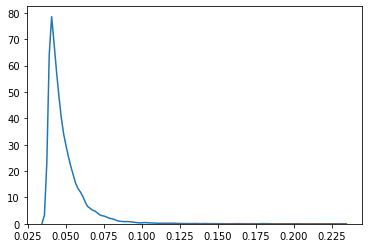

In [13]:
# get non-zero injected links
indexes = injection_final.nonzero()
index_arr = np.stack(indexes)
values = injection_final[indexes]

# sort injected links
sorted_idx = np.flip(np.argsort(values))

sorted_index = index_arr[:, sorted_idx]
sorted_values = values[sorted_idx]

# get the largest N out
num_edges = data.edge_index.size(1)
pred_index = sorted_index[:, :num_edges].T
pred_values = sorted_values[:num_edges]
print(pred_index)
print(pred_values)
print(pred_index.shape)
print(pred_values.shape)

sns.distplot(pred_values, hist=False)
plt.show()

In [14]:
if False:
    np.save('../variables/sorted_GCN_injection', sorted_index)
    np.save('../variables/sorted_GCN_weights', sorted_values)

In [15]:
# get the highest score out
print(pred_index[:10])
print(pred_values[:10])

[[2622  537]
 [ 213  537]
 [2622  145]
 [ 108 2160]
 [2622 1165]
 [ 144  537]
 [ 898 2160]
 [2622 1593]
 [2622 1698]
 [1593 2192]]
[0.23040664 0.2124002  0.20239711 0.20137182 0.18056369 0.18013139
 0.17933021 0.17853545 0.17265803 0.1725375 ]


### Visualize Top-1 Neighborhood

In [16]:
def show_ego_graph(data, index):
    # convert to graph
    G = torch_geometric.utils.to_networkx(
        dataset.data, node_attrs=None, edge_attrs=None
    )

    # Create ego graph of main hub
    hub_ego = nx.ego_graph(G, index, radius=2)

    # Draw graph
    pos = nx.spring_layout(hub_ego)
    nx.draw(hub_ego, pos, node_color='b', node_size=50, with_labels=False)

    # Draw ego as large and red
    nx.draw_networkx_nodes(hub_ego, pos, nodelist=[index], node_size=100, node_color='r')
    plt.show()

def show_link_graph(data, src, dst, numbering=None):
    # convert to graph
    G = torch_geometric.utils.to_networkx(
        dataset.data, node_attrs=None, edge_attrs=None
    )

    # Create ego graph of main hub
    src_ego = nx.ego_graph(G, src, radius=2)
    dst_ego = nx.ego_graph(G, dst, radius=2)
    
    hub_ego = nx.algorithms.operators.binary.compose(src_ego, dst_ego)
    
    f = plt.figure(figsize=(8, 6))
    
    # Draw graph
    pos = nx.spring_layout(hub_ego)
    nx.draw(hub_ego, pos, node_color='b', node_size=50, with_labels=False, alpha=0.2)
    
    # Draw ego as large and red
    nx.draw_networkx_nodes(hub_ego, pos, nodelist=[src, dst], node_size=100, node_color='r', alpha=0.8)
    if numbering is None:
        f.savefig("link_graph.pdf", bbox_inches='tight')
    else:
        f.savefig("link_graph_%d.pdf" % numbering, bbox_inches='tight')
    plt.show()

/home/jayroxis/venv/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/jayroxis/venv/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


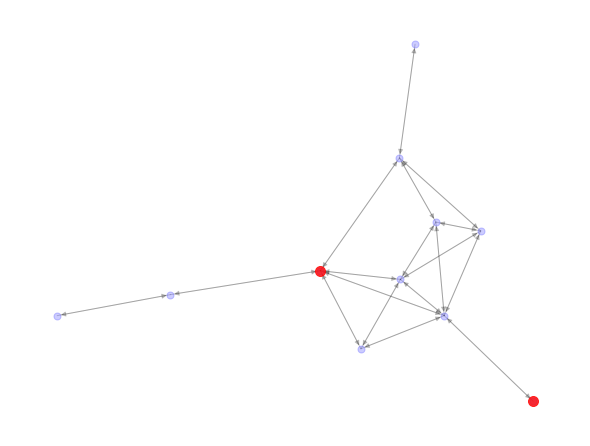

In [17]:
show_link_graph(data, pred_index[0][0], pred_index[0][1])

### Top 50 Shortest Path

In [18]:
G = torch_geometric.utils.to_networkx(
        dataset.data, node_attrs=None, edge_attrs=None
    )

for src, dst in pred_index[:50]:
    if nx.has_path(G, source=src, target=dst):
        shortest_path = nx.shortest_path(G, source=src, target=src)
        print(src, dst, shortest_path, len(shortest_path))
    else:
        print(src, dst, nx.has_path(G, source=src, target=dst))

2622 537 [2622] 1
213 537 [213] 1
2622 145 [2622] 1
108 2160 [108] 1
2622 1165 [2622] 1
144 537 [144] 1
898 2160 [898] 1
2622 1593 [2622] 1
2622 1698 [2622] 1
1593 2192 [1593] 1
2622 213 [2622] 1
23 2160 [23] 1
495 537 [495] 1
1698 2192 [1698] 1
2622 2161 [2622] 1
2622 1328 [2622] 1
23 2157 [23] 1
2192 145 [2192] 1
1698 145 [1698] 1
2622 1835 [2622] 1
144 145 [144] 1
1698 2161 [1698] 1
123 122 [123] 1
1328 1698 [1328] 1
2370 2367 [2370] 1
2622 2192 [2622] 1
108 1504 [108] 1
2161 1327 [2161] 1
273 2146 [273] 1
92 898 [92] 1
1698 1328 [1698] 1
2192 1593 [2192] 1
2622 1327 [2622] 1
2192 1327 [2192] 1
1698 1165 [1698] 1
495 213 [495] 1
2622 1504 [2622] 1
2192 1698 [2192] 1
640 2367 [640] 1
2192 1328 [2192] 1
284 75 [284] 1
2622 991 False
2622 108 [2622] 1
1698 1835 [1698] 1
1698 1593 [1698] 1
2161 1328 [2161] 1
1328 537 [1328] 1
1328 2160 [1328] 1
1044 2161 False
1044 991 False


In [19]:
# find out how many injected links are in the graph
true_index = data.edge_index.cpu().numpy().T

start = true_index[:, 0]

unq_val, unq_idx = np.unique(start, return_index=True)
start_dict = dict(zip(unq_val, unq_idx))

correct_list = []
for i in range(len(pred_index)):
    pred = pred_index[i]
    if pred[0] in start_dict:
        begin = start_dict[pred[0]]
        if pred[0] + 1 in start_dict:
            end = start_dict[pred[0] + 1]
        else:
            end = len(true_index)
    for j in range(begin, end):
        true = true_index[j]
        if np.array_equal(pred, true):
            print(i, j, pred, true)
            correct_list.append((i, pred))
            break

2 10377 [2622  145] [2622  145]
6 3562 [ 898 2160] [ 898 2160]
20 651 [144 145] [144 145]
24 9696 [2370 2367] [2370 2367]
27 8940 [2161 1327] [2161 1327]
29 393 [ 92 898] [ 92 898]
47 5155 [1328 2160] [1328 2160]
58 10001 [2463   89] [2463   89]
60 474 [ 108 2157] [ 108 2157]
64 6292 [1593  144] [1593  144]
73 3669 [938 618] [938 618]
87 76 [  23 2159] [  23 2159]
92 4230 [1087   89] [1087   89]
93 6296 [1593 1165] [1593 1165]
105 5153 [1328  495] [1328  495]
107 2245 [ 548 1523] [ 548 1523]
131 7470 [1835 2157] [1835 2157]
134 9135 [2209  108] [2209  108]
156 88 [26 99] [26 99]
158 1568 [ 385 2484] [ 385 2484]
170 10055 [2479 1236] [2479 1236]
182 6526 [1647  108] [1647  108]
194 4291 [1101 2146] [1101 2146]
220 9272 [2242 2539] [2242 2539]
224 2516 [ 614 1475] [ 614 1475]
230 4091 [1050 2564] [1050 2564]
237 10276 [2569  380] [2569  380]
253 92 [  26 2455] [  26 2455]
264 5094 [1310 2692] [1310 2692]
293 1107 [273 374] [273 374]
294 3869 [ 998 1431] [ 998 1431]
313 10061 [2482  167] 

### Top Injected Links (Predicted Use Link Injection)

In [20]:
path_length = []
src_list, dst_list = [], []

for src, dst in pred_index:
    src_list.append(src)
    dst_list.append(dst)
    if nx.has_path(G, source=src, target=dst):
        shortest_path = nx.shortest_path(G, source=src, target=src)
        path_length.append(len(shortest_path))
    else:
        path_length.append(0)
        
path_length = np.array(path_length)

In [21]:
num_pred = pred_index.shape[0]

direct_link = np.sum(path_length == 1) / num_pred # directed connected,i.e., neighbors
indirect_link = np.sum(path_length > 1)/ num_pred # have a path between but not neighbors
unconnected = np.sum(path_length == 0) / num_pred # directed connected,i.e., neighbors
unconnected_pos = np.where(path_length == 0)[0]

print(direct_link)
print(indirect_link)
print(unconnected)
print(np.mean(unconnected_pos))

0.510989010989011
0.0
0.489010989010989
5355.354707477722


In [22]:
0.6072375899962107 * 10556

6410.0

41 [2622  991]
tensor(6, device='cuda:1') tensor(6, device='cuda:1')


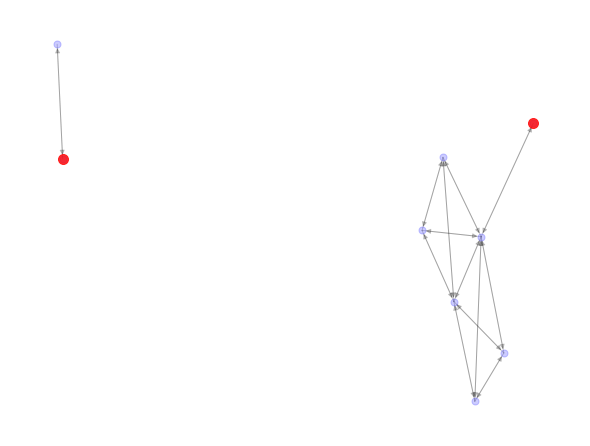

48 [1044 2161]
tensor(3, device='cuda:1') tensor(6, device='cuda:1')


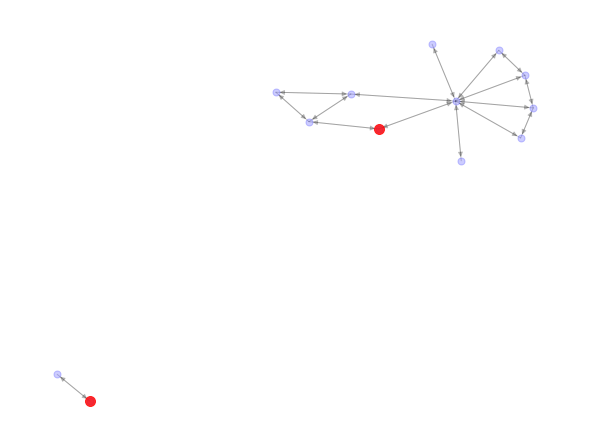

49 [1044  991]
tensor(3, device='cuda:1') tensor(6, device='cuda:1')


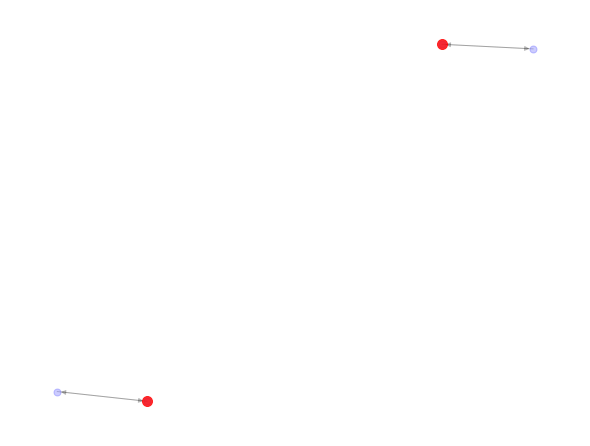

56 [1044 1328]
tensor(3, device='cuda:1') tensor(6, device='cuda:1')


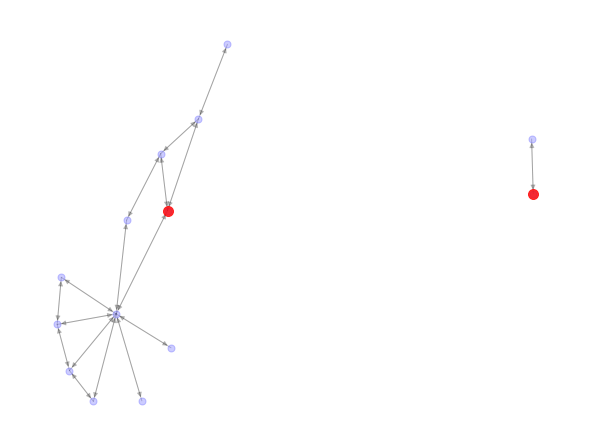

57 [1044 1698]
tensor(3, device='cuda:1') tensor(6, device='cuda:1')


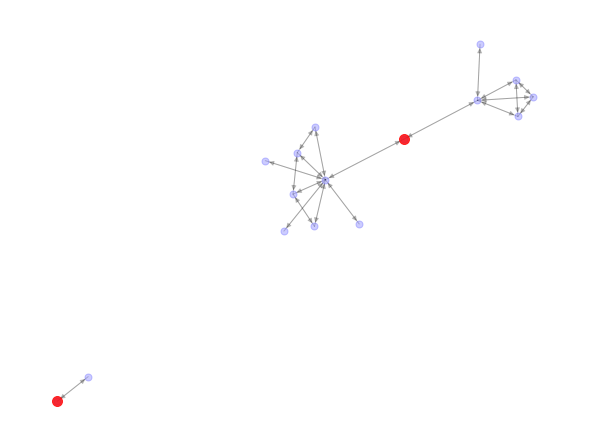

In [23]:
for i in range(5):
    idx = unconnected_pos[i]
    print(idx, pred_index[idx])
    src = pred_index[idx][0]
    dst = pred_index[idx][1]
    print(data.y[src], data.y[dst])
    show_link_graph(data, src, dst, numbering=i+1)

In [24]:
hit_rate = len(correct_list) / num_edges
print('hits =', len(correct_list))
print('hit rate =', hit_rate)
print('number of top-scored predictions =', len(pred_index))
print('number of edges in the graph =', len(true_index))
num_options = len(true_index) ** 2
print('p =', 1 / num_options)
print('significance =', hit_rate * num_options)

MR = np.mean(np.array([item[0] for item in correct_list]))
print('MR =', MR)
print('MR Ratio =', 1 - MR / num_edges)

hits = 129
hit rate = 0.012220538082607047
number of top-scored predictions = 10556
number of edges in the graph = 10556
p = 8.974313504503885e-09
significance = 1361724.0
MR = 2489.6201550387595
MR Ratio = 0.7641511789466882


In [25]:
print('%.3f\\%%' % (0.017241379310344827 * 5 * 100))

8.621\%
